# Does replaying the same movie clip reduce the variability of resting-state fMRI?

In [144]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from bids import BIDSLayout

# Define paths
fc_path = Path("/data/derivatives/hcph-derivatives-rsmovie/functional_connectivity/DiFuMo64-LP/sub-001")
dataset_path = Path("/data/datasets/hcph-dataset")

## Load the functional connectivity matrices

(2080, 36)


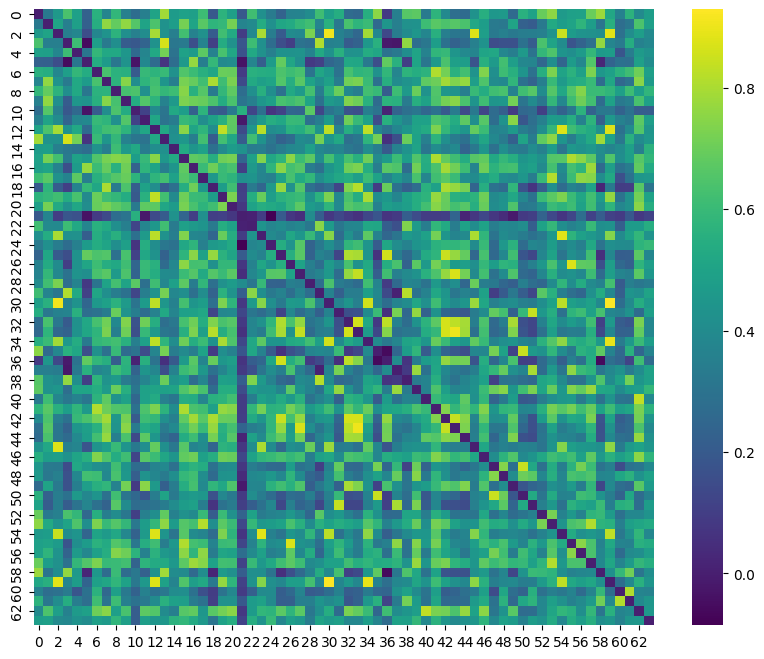

In [145]:
# Keep only upper-triangle since the FC matrix is symmetric (does the diagonal of our FC contain only ones ? if yes can discard the diagonal, if not have to keep it 

# Initialize the BIDS layout
layout = BIDSLayout(fc_path, validate=False)

# Get all the files matching the pattern
files = layout.get(subject='001', task='rsmovie', suffix='connectivity', extension='tsv', return_type='file')

# Meas is not a recognized entity by PyBIDS, so I am filtering for meas-connectivity separately
# Keep only files with 'meas-correlation' in the filename
files = [f for f in files if 'meas-correlation' in f]
assert len(files) == 36, f"Expected 36 FC matrices, got {len(files)}"

# Load the data from each file and concatenate
fc_matrices = []
for file in files:
    fc_matrix = pd.read_csv(file, sep='\t', header=None)
    fc_matrices.append(fc_matrix.values[np.triu_indices_from(fc_matrix, k=0)])

# Store the matrix size for reconstruction later
fc_size = fc_matrix.shape[0]
# Concatenate all the upper triangle values
fc_concat = np.vstack(fc_matrices)
# Transport matrix
fc_concat = fc_concat.T

#Plot an example FC matrix
plt.figure(figsize=(10, 8))
sns.heatmap(fc_matrix, cmap='viridis')

# Generate a random matrix of size 2080x36
#fc_concat = np.random.rand(2080, 36)
print(fc_concat.shape)

## Run PCA to estimate the residual variance for each rsfMRI run

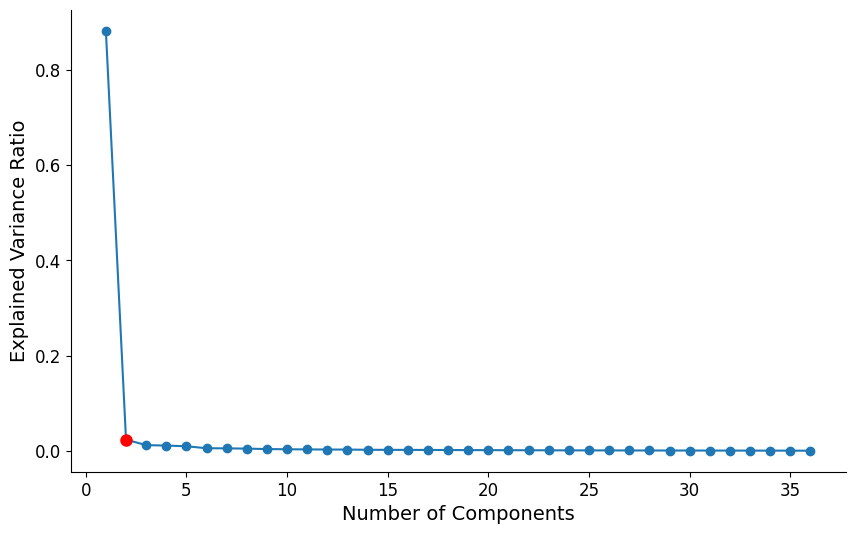

In [146]:
from sklearn.decomposition import PCA

# Run PCA
# Center the data by removing the mean from each session
fc_concat = fc_concat - np.mean(fc_concat, axis=0)

# Standardize the data to have unit variance
fc_concat = fc_concat / np.std(fc_concat, axis=0)

# Run PCA
pca = PCA()
pca.fit(fc_concat)

# Calculate the explained variance
explained_variance = pca.explained_variance_ratio_

# Generate the elbow plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-')
ax.set_xlabel('Number of Components', fontsize=14)
ax.set_ylabel('Explained Variance Ratio', fontsize=14)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#Define the number of components to keep
n_comp = 2

# Highlight the points corresponding to number of components we keep in red
ax.plot(n_comp, explained_variance[n_comp-1], marker='o', markersize=8, color='red')

plt.show()

We are using the elbow plot to decide the number of principal components to keep.

In [147]:
# Calculate the eigenvalues from the explained variance
eigenvalues = pca.explained_variance_
print(f"Eigenvalues: {eigenvalues}")   

# Apply the Kaiser criterion
n_comp_kaiser = np.sum(eigenvalues > 1)
print(f"Number of components according to the Kaiser criterion: {n_comp_kaiser}")

Eigenvalues: [3.17454034e+01 8.53859103e-01 4.37869786e-01 4.06409268e-01
 3.52139329e-01 2.04805620e-01 1.93578523e-01 1.75510372e-01
 1.41090321e-01 1.26289518e-01 1.15498815e-01 1.06072135e-01
 1.02867332e-01 8.59980002e-02 8.18426945e-02 7.76877571e-02
 7.41371634e-02 6.90253653e-02 6.20227050e-02 5.94006019e-02
 5.54126482e-02 5.16116212e-02 4.69416557e-02 4.21943525e-02
 4.06102254e-02 3.98111140e-02 3.50395967e-02 3.36418607e-02
 3.15534957e-02 3.07715631e-02 2.76547874e-02 2.64417427e-02
 2.40418825e-02 2.28930564e-02 2.14094515e-02 1.57791984e-02]
Number of components according to the Kaiser criterion: 1


## Reconstruct the FC with a limited number of components

After extracting the principal components, each FC matrix can be expressed as a linear combinations of the principal components plus a residual matrix.

In [148]:
print(pca.components_.shape)
# Project PC components back into each FC subject space
fc_projected = pca.transform(fc_concat)[:, :n_comp]
print(fc_projected.shape)
fc_reconstructed = np.dot(fc_projected, pca.components_[:n_comp, :]) + np.mean(fc_concat, axis=0)
print(fc_reconstructed.shape)

(36, 36)
(2080, 2)
(2080, 36)


## Compute the residual matrix

In [149]:
# Calculate the residuals as the difference between the full and reconstructed FC matrices
residuals = fc_concat - fc_reconstructed
print(residuals.shape)

(2080, 36)


In [150]:
import numpy as np
from sklearn.decomposition import PCA

# Project the data onto the residual components (from n_comp + 1 onwards)
residuals_frompc = pca.transform(fc_concat)[:, n_comp:]

# Reconstruct the data using the residual components
residuals_frompc = np.dot(residuals_frompc, pca.components_[n_comp:, :]) + np.mean(fc_concat, axis=0)

# Print the shape of the reconstructed data
print(residuals_frompc.shape)


(2080, 36)


## Plot residual matrix

In [151]:
# Function to reconstruct the full matrix from the upper triangle
def reconstruct_full_matrix(upper_triangle, size):
    full_matrix = np.zeros((size, size))
    upper_indices = np.triu_indices(size)
    full_matrix[upper_indices] = upper_triangle
    full_matrix = full_matrix + full_matrix.T - np.diag(np.diag(full_matrix))
    return full_matrix

# Test my reconstruction function
upper_triangle = fc_matrix.values[np.triu_indices_from(fc_matrix, k=0)]
full_matrix = reconstruct_full_matrix(upper_triangle, fc_size)
full_matrix.shape
assert np.array_equal(full_matrix, fc_matrix.values)

[-0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393]


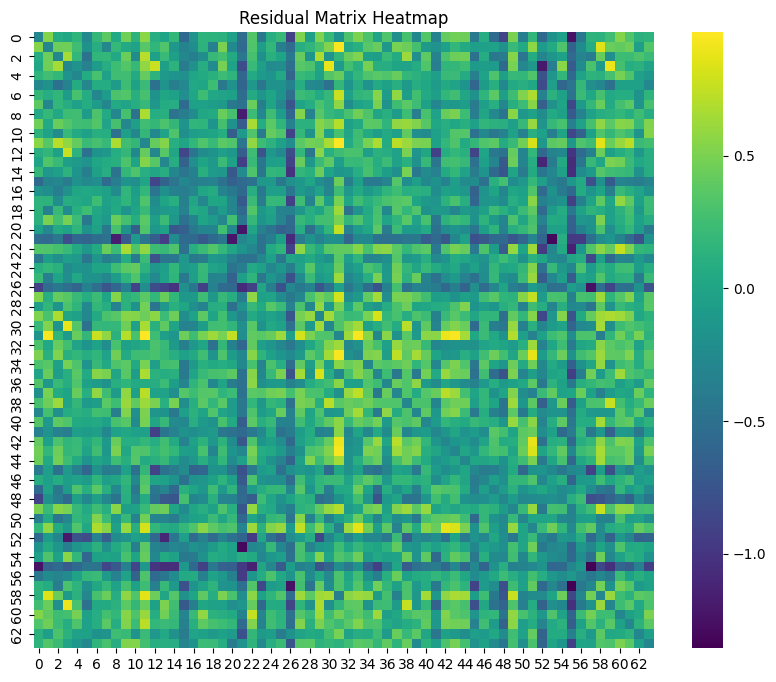

In [152]:
residual = reconstruct_full_matrix(residuals[:,0], fc_size)
print(np.diag(residual))

# Plot the residual matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(residual, cmap='viridis')
plt.title('Residual Matrix Heatmap')
plt.show()

[-0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393 -0.28188393
 -0.28188393 -0.28188393 -0.28188393 -0.28188393]


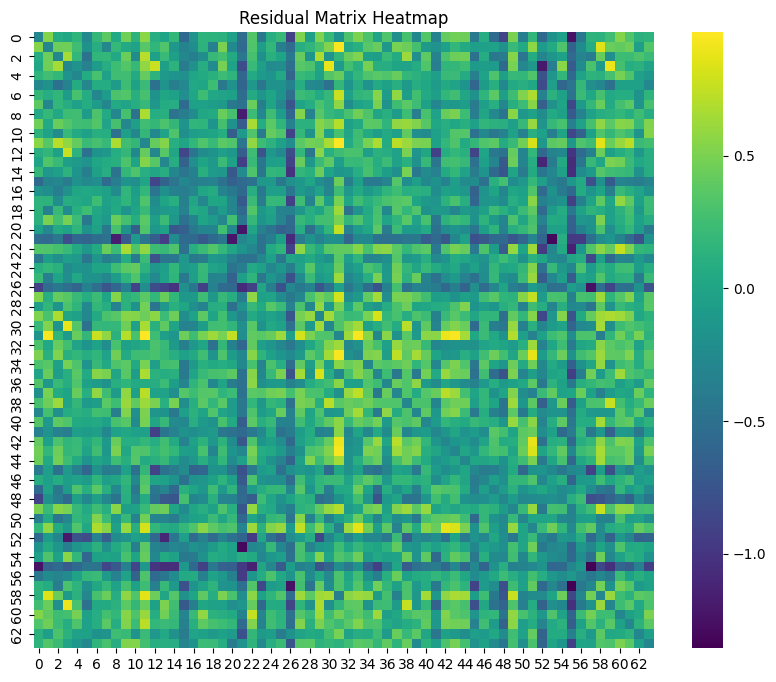

In [153]:
# Assuming the size of the original FC matrix is 64x64
size = 64
residual_frompc = reconstruct_full_matrix(residuals_frompc[:,0], size)
print(np.diag(residual))

# Plot the residual matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(residual_frompc, cmap='viridis')
plt.title('Residual Matrix Heatmap')
plt.show()

## Plot the variance of the residuals over sessions

In [154]:
def plot_res_variance(residuals, groupedby=False):
    from scipy.optimize import curve_fit
    from sklearn.metrics import r2_score
    
    # Compute the variance of the residuals for each session
    residuals_var = np.var(residuals, axis=0)

    # Plot the variance of the residuals as a function of the session index
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(residuals_var)), residuals_var, marker='o', linestyle='-', label='Variance of Residuals')

    # Fit and plot a linear curve
    linear_model = np.poly1d(np.polyfit(range(len(residuals_var)), residuals_var, 1))
    linear_r2 = r2_score(residuals_var, linear_model(range(len(residuals_var))))
    plt.plot(range(len(residuals_var)), linear_model(range(len(residuals_var))), linestyle='--', label=f'Linear Fit (R$^2$={linear_r2:.2f})')

    # Fit and plot a quadratic curve
    quadratic_model = np.poly1d(np.polyfit(range(len(residuals_var)), residuals_var, 2))
    quadratic_r2 = r2_score(residuals_var, quadratic_model(range(len(residuals_var))))
    plt.plot(range(len(residuals_var)), quadratic_model(range(len(residuals_var))), linestyle='--', label=f'Quadratic Fit (R$^2$={quadratic_r2:.2f})')

    # Fit and plot a negative exponential curve
    def neg_exp(x, a, b, c):
        return a * np.exp(-b * x) + c

    #popt, _ = curve_fit(neg_exp, range(len(residuals_var)), residuals_var, p0=(1, 0.01, 1))
    #neg_exp_r2 = r2_score(residuals_var, neg_exp(range(len(residuals_var)), *popt))
    #plt.plot(range(len(residuals_var)), neg_exp(range(len(residuals_var)), *popt), linestyle='--', label=f'Negative Exponential Fit (R$^2$={neg_exp_r2:.2f})')

    plt.xlabel('Session Index', fontsize=14)
    plt.ylabel('Variance of Residuals', fontsize=14)
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)
    plt.legend()
    if groupedby:
        plt.title(groupedby, fontsize=16)
    
    plt.show()
   

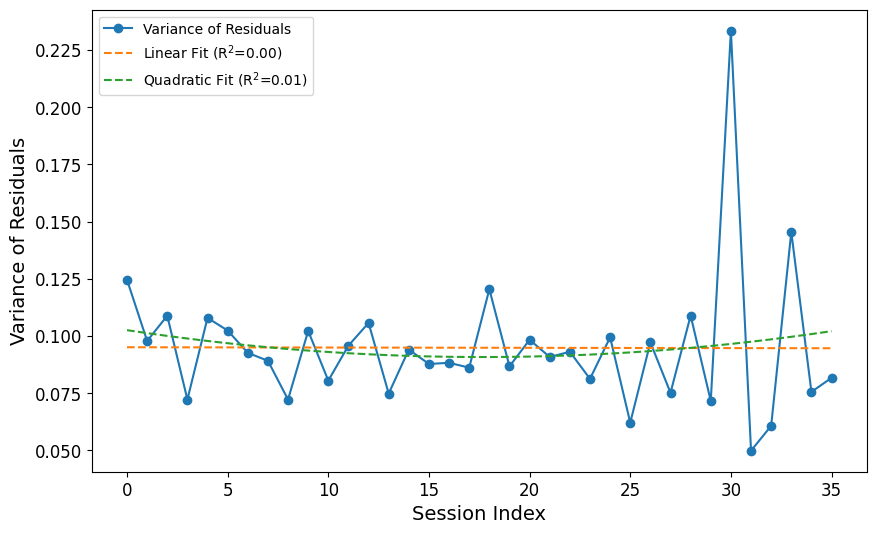

(2080, 36)

In [155]:
plot_res_variance(residuals)
residuals.shape

## Plot edgewise residual over sessions

In [156]:
def plot_edgewise_residual(residuals, groupedby=False):
    # Calculate the interquartile range (IQR)
    q1 = np.percentile(residuals, 25, axis=0)
    q3 = np.percentile(residuals, 75, axis=0)

    # Plot the evolution of the residual for each edge
    for i in range(residuals.shape[0]):
        plt.plot(range(residuals.shape[1]), residuals[i,:], color='blue', alpha=0.1)

    # Plot the inter-quartile
    plt.plot(range(residuals.shape[1]), q1, color='orange', label='25th percentile')
    plt.plot(range(residuals.shape[1]), q3, color='orange', label='75th percentile')


    plt.xlabel('Session Index', fontsize=14)
    plt.ylabel('Residual Value', fontsize=14)
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)
    plt.legend()
    if groupedby:
        plt.title(groupedby, fontsize=16)
        
    plt.show()


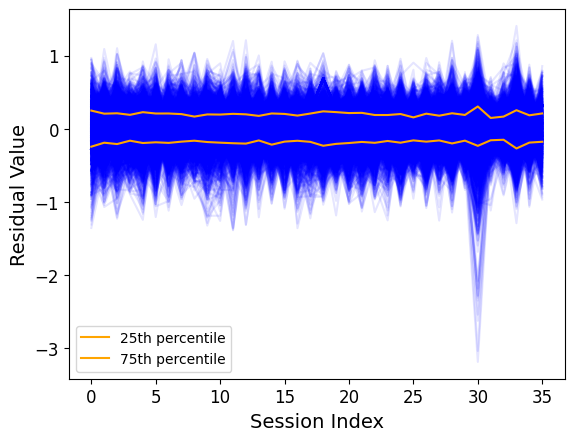

In [157]:
plot_edgewise_residual(residuals)

#Retrieve confounds

### Retrieve scan time and day of week from the `scans.tsv` in the dataset repo

In [158]:
# Read the scans.tsv file
scans_df = pd.read_csv(dataset_path / "scans.tsv", sep='\t')
scans_df.drop(columns=["randstr"], inplace=True)

#Extract entities
# Each echo and magnitude and phase part of each functional scans are recorded on separate line, 
# but we have only one final image so keep only one of the identical acq_time
scans_df = scans_df.drop_duplicates(subset=["acq_time"])
scans_df = scans_df.assign(
    subject=scans_df["filename"].str.extract(r"sub-(\d+)/"),
    session=scans_df["filename"].str.extract(r"ses-(\w+)/"),
    modality=scans_df["filename"].str.split("/").str[2],
    task=scans_df["filename"].str.extract(r"task-(\w+)_"),
)
# Keep only the magnitude part of functional scans and first echo
scans_df = scans_df[scans_df["modality"] == "func"]

# Create dataframe based on the list of files
files_df = pd.DataFrame(files, columns=['file_path'])
files_df = files_df.assign(
    subject=files_df["file_path"].str.extract(r"sub-(\d+)/"),
    session=files_df["file_path"].str.extract(r"ses-(\w+)/"),
    task=files_df["file_path"].str.extract(r"task-(\w+)_"),
)

#Pair filenames with acquisition time
confounds_df = pd.merge(
        scans_df, files_df, on=["subject", "session", "task"], how="inner"
    )
confounds_df.drop(columns=["file_path"], inplace=True)

# From the acq_time column, extract the day of week and time of day
confounds_df = confounds_df.assign(datetime = pd.to_datetime(confounds_df["acq_time"]))
confounds_df = confounds_df.assign(
    day_of_week = confounds_df['datetime'].dt.day_name(),
    time_of_day = confounds_df['datetime'].dt.round('H').dt.time
)
confounds_df.drop(columns=["datetime"], inplace=True)
print(confounds_df.head())


                                            filename  \
0  sub-001/ses-001/func/sub-001_ses-001_task-rsmo...   
1  sub-001/ses-003/func/sub-001_ses-003_task-rsmo...   
2  sub-001/ses-004/func/sub-001_ses-004_task-rsmo...   
3  sub-001/ses-005/func/sub-001_ses-005_task-rsmo...   
4  sub-001/ses-006/func/sub-001_ses-006_task-rsmo...   

                     acq_time subject session modality     task day_of_week  \
0  2023-10-20T19:50:01.187500     001     001     func  rsmovie      Friday   
1  2023-10-21T10:12:32.207500     001     003     func  rsmovie    Saturday   
2  2023-10-21T12:22:08.222500     001     004     func  rsmovie    Saturday   
3  2023-10-22T10:33:53.380000     001     005     func  rsmovie      Sunday   
4  2023-10-22T12:18:06.200000     001     006     func  rsmovie      Sunday   

  time_of_day  
0    20:00:00  
1    10:00:00  
2    12:00:00  
3    11:00:00  
4    12:00:00  


### Retrieve coffee consumption from the issues in the GitHub repository of confound collection

In [159]:
""" # GitHub repository details
repo_owner = 'TheAxonLab'  # Replace with your GitHub username or org name
repo_name = 'hcph-mood-quest'
# Read token from token.txt
with open('token.txt', 'r') as file:
    token = file.read().strip()

# GitHub API headers
headers = {
    'Authorization': f'token {token}',
    'Accept': 'application/vnd.github.v3+json'
}

# Regular expression to match issue titles with the optional [BEFORE] tag and confounds of interest
issue_title_pattern = r'\[MOOD\](?:\[BEFORE\])? sub-001_ses-0\d{2}'
caffeine_2h_pattern = r'### Caffeine intake in the last 2h \(# cups\)\s+(\d+)'
caffeine_24h_pattern = r'### Caffeine intake in the last 24h \(# cups\)\s+(\d+)'

def get_confounds_in_issues():
    data = []
    page = 1

    while True:
        url = f'https://api.github.com/repos/{repo_owner}/{repo_name}/issues'
        params = {'state': 'all', 'per_page': 100, 'page': page}
        response = requests.get(url, headers=headers, params=params)
        issues = response.json()
        print(issues)
        
        # Stop if no more issues
        if not issues:
            break

        for issue in issues:
            title = issue['title']
            if re.search(issue_title_pattern, title):
                # Get the issue body
                issue_body = issue['body']

                # Extract scan time, and confounds of interest
                caffeine_2h = re.search(caffeine_2h_pattern, issue_body)
                caffeine_24h = re.search(caffeine_24h_pattern, issue_body)
                
                data.append({
                    'IssueTitle': title,
                    'CaffeineIntake2h': int(caffeine_2h.group(1)) if caffeine_2h else None,
                    'CaffeineIntake24h': int(caffeine_24h.group(1)) if caffeine_24h else None
                })
        
        page += 1

    return pd.DataFrame(data)

# Retrieve scan times
coffee_df = get_confounds_in_issues()

print(confounds_df) """

" # GitHub repository details\nrepo_owner = 'TheAxonLab'  # Replace with your GitHub username or org name\nrepo_name = 'hcph-mood-quest'\n# Read token from token.txt\nwith open('token.txt', 'r') as file:\n    token = file.read().strip()\n\n# GitHub API headers\nheaders = {\n    'Authorization': f'token {token}',\n    'Accept': 'application/vnd.github.v3+json'\n}\n\n# Regular expression to match issue titles with the optional [BEFORE] tag and confounds of interest\nissue_title_pattern = r'\\[MOOD\\](?:\\[BEFORE\\])? sub-001_ses-0\\d{2}'\ncaffeine_2h_pattern = r'### Caffeine intake in the last 2h \\(# cups\\)\\s+(\\d+)'\ncaffeine_24h_pattern = r'### Caffeine intake in the last 24h \\(# cups\\)\\s+(\\d+)'\n\ndef get_confounds_in_issues():\n    data = []\n    page = 1\n\n    while True:\n        url = f'https://api.github.com/repos/{repo_owner}/{repo_name}/issues'\n        params = {'state': 'all', 'per_page': 100, 'page': page}\n        response = requests.get(url, headers=headers, params

# Plot residuals grouped by bins of confound factor

In [160]:
# Merge residuals with confounds_df to get the time_of_day for each session
residuals_df = pd.DataFrame(residuals.T)
residuals_df = residuals_df.assign(
    session = files_df['session'],
)
residuals_df = pd.merge(residuals_df, confounds_df[['session', 'day_of_week', 'time_of_day']], on='session')
print(residuals_df.shape)
print(residuals_df.head())

(36, 2083)
          0         1         2         3         4         5         6  \
0 -0.281884  0.534920  0.074180  0.026243  0.153221 -0.265629  0.182824   
1 -0.150869  0.455489  0.623652  0.129800  0.583181 -0.295119  0.060452   
2 -0.053486  0.213440 -0.084627  0.222646  0.171060  0.653089  0.368633   
3 -0.160739 -0.051417 -0.208557  0.046668  0.062290  0.140221  0.122170   
4 -0.062916  0.201484 -0.044047  0.076067 -0.335618  0.542638  0.113707   

          7         8         9  ...      2073      2074      2075      2076  \
0  0.380444  0.044168  0.463476  ...  0.505833 -0.281884  0.137314  0.370439   
1  0.210795  0.220235 -0.090242  ... -0.559630 -0.150869 -0.245623 -0.123714   
2  0.812596  0.147274  0.565942  ... -0.088647 -0.053486 -0.074511  0.115348   
3  0.191254 -0.287727  0.063037  ...  0.634829 -0.160739  0.309968  0.614112   
4  0.195059 -0.343701  0.392655  ...  0.154881 -0.062916  0.405977  0.102501   

       2077      2078      2079  session  day_of_week  ti

## Day of week

Plotting residuals variance for day of week: Friday


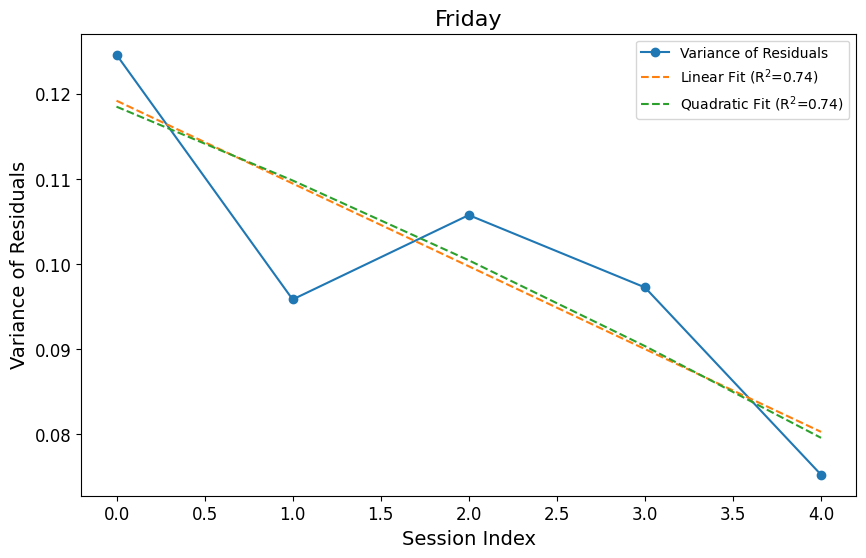

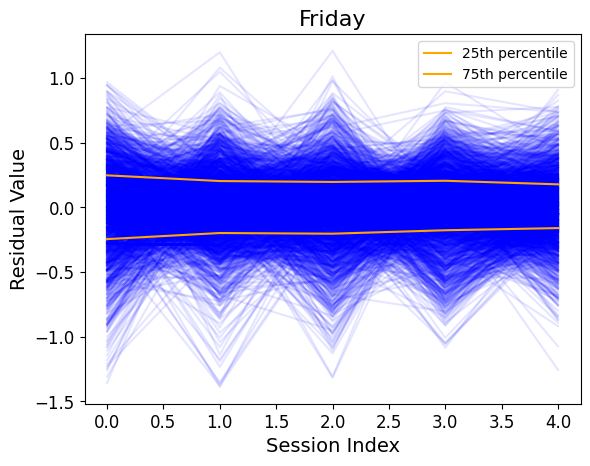

Plotting residuals variance for day of week: Monday


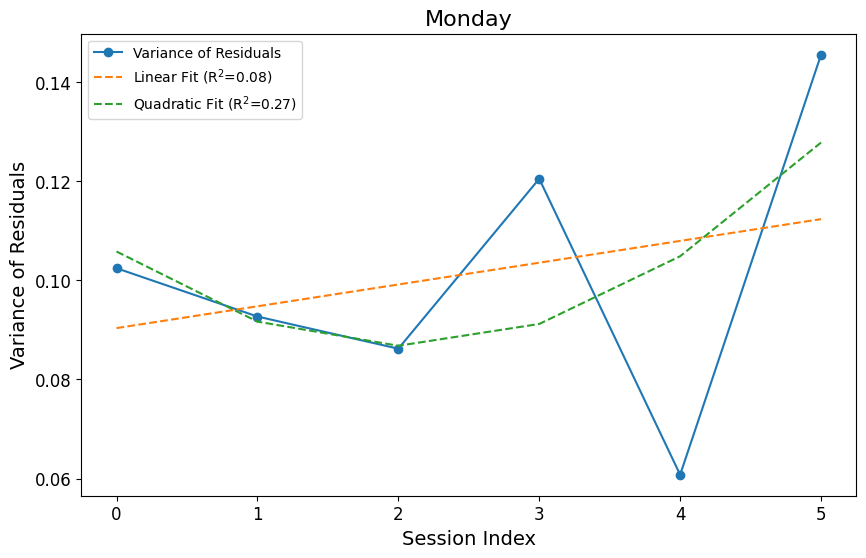

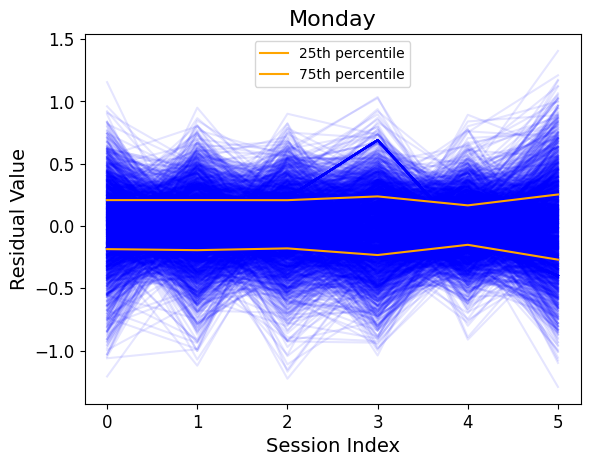

Plotting residuals variance for day of week: Saturday


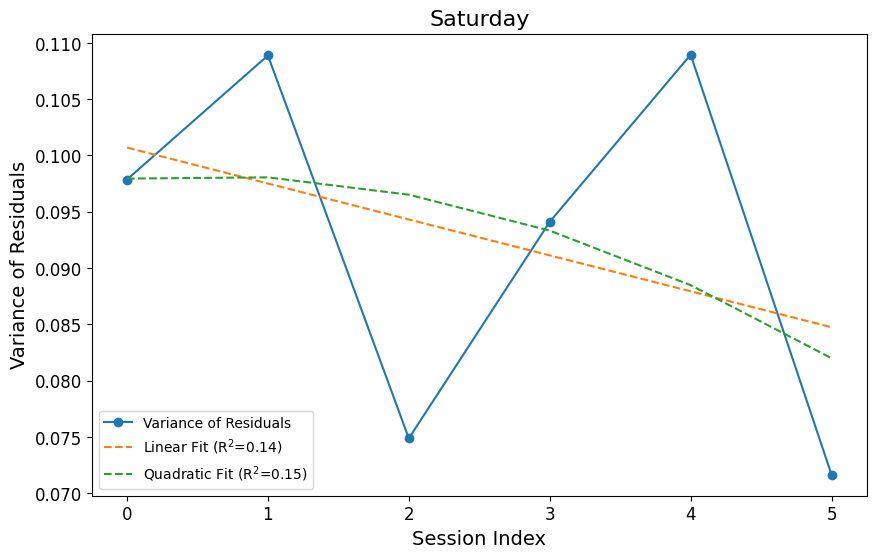

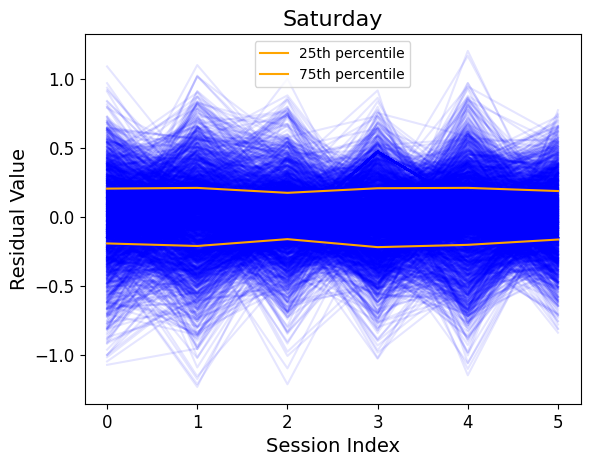

Plotting residuals variance for day of week: Sunday


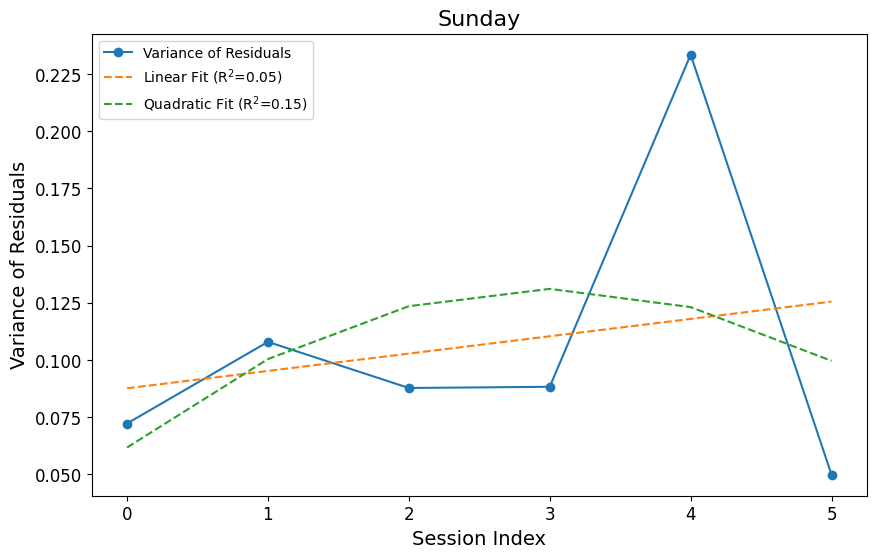

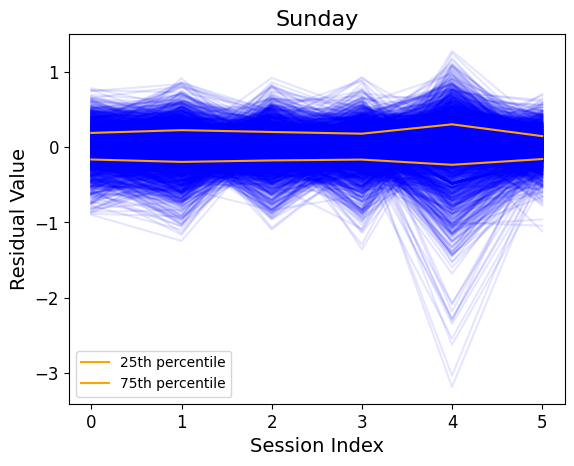

Plotting residuals variance for day of week: Thursday


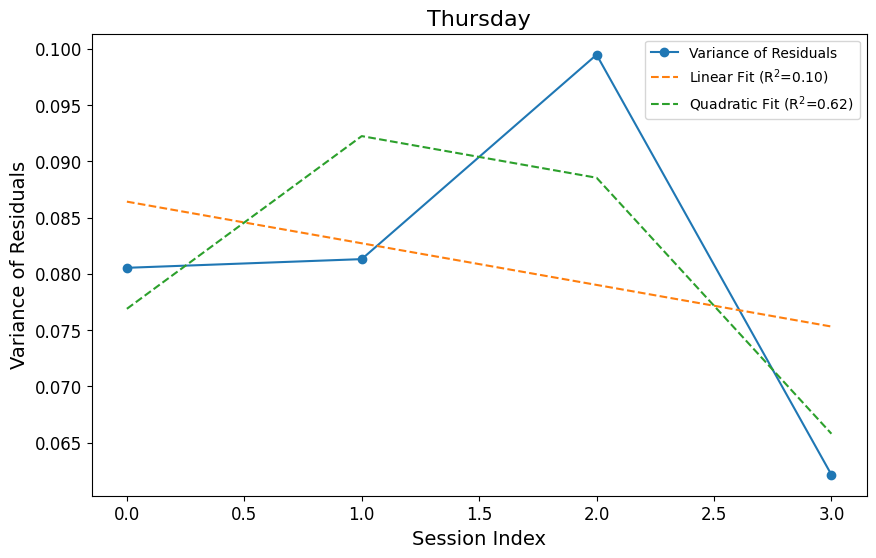

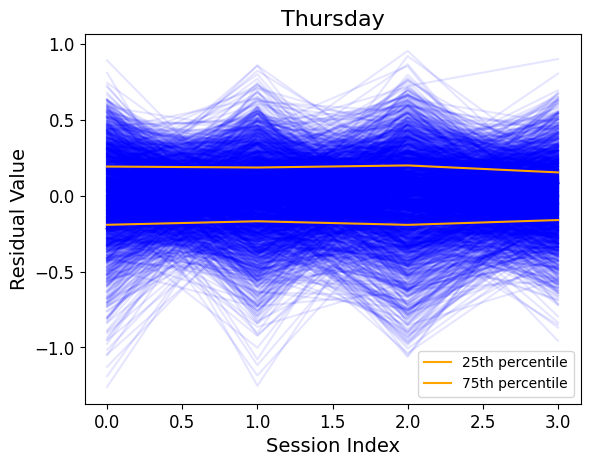

Plotting residuals variance for day of week: Tuesday


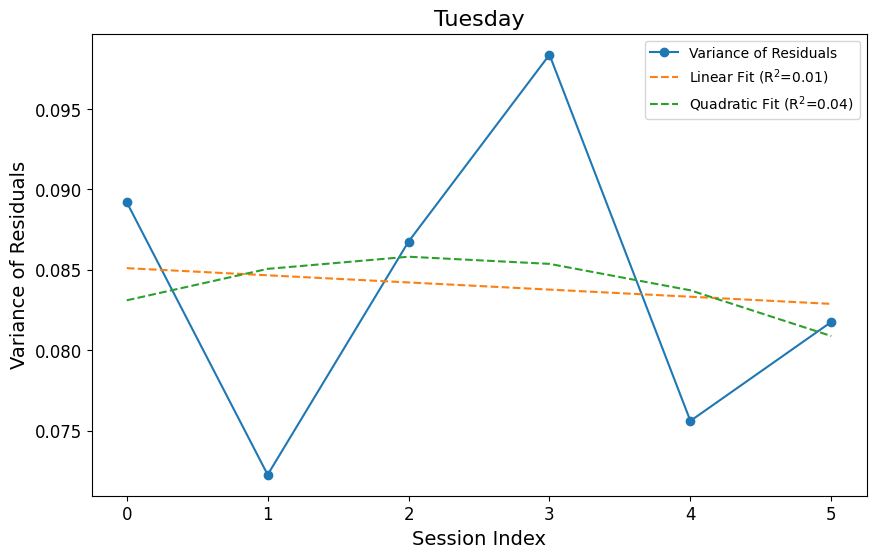

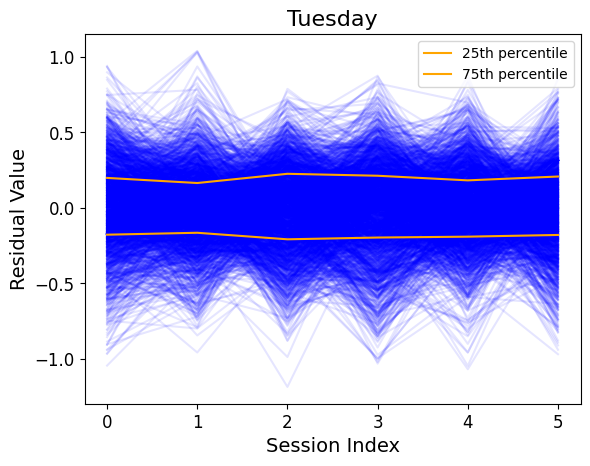

Plotting residuals variance for day of week: Wednesday


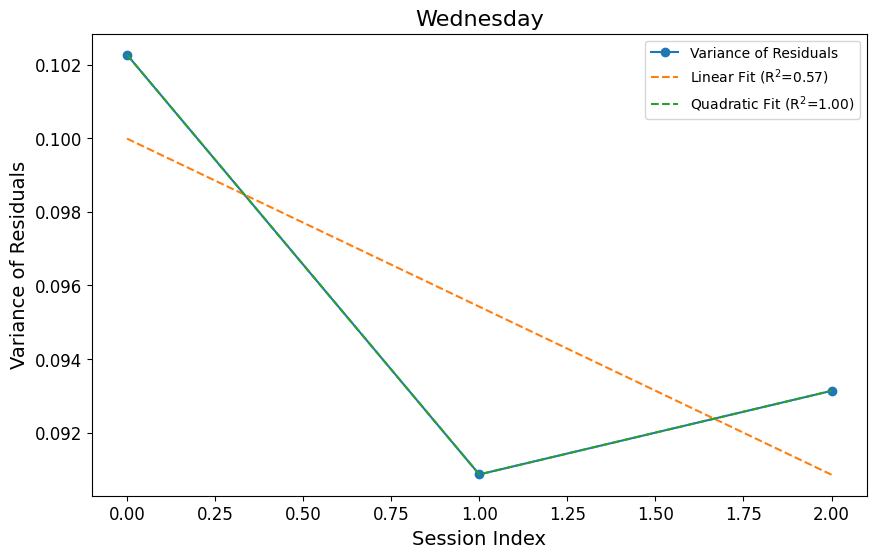

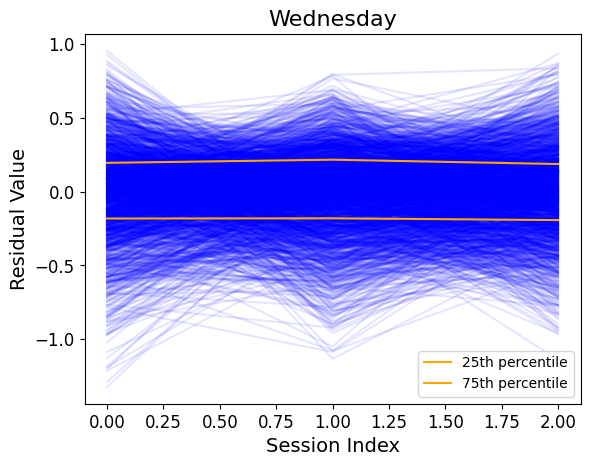

In [161]:
# Group by day of week and plot residuals variance for each group
for day_of_week, group in residuals_df.groupby('day_of_week'):
    print(f"Plotting residuals variance for day of week: {day_of_week}")
    res = group.drop(columns=['session', 'day_of_week', 'time_of_day']).values.T
    plot_res_variance(res, groupedby=day_of_week)
    plot_edgewise_residual(res, groupedby=day_of_week)

## Time of day

Plotting residuals variance for time_of_day: 09:00:00
(2080, 1)
Plotting residuals variance for time_of_day: 10:00:00
(2080, 2)


/tmp/ipykernel_1550129/2570885129.py:7: RankWarning: Polyfit may be poorly conditioned
  plot_res_variance(res, groupedby=time_of_day)


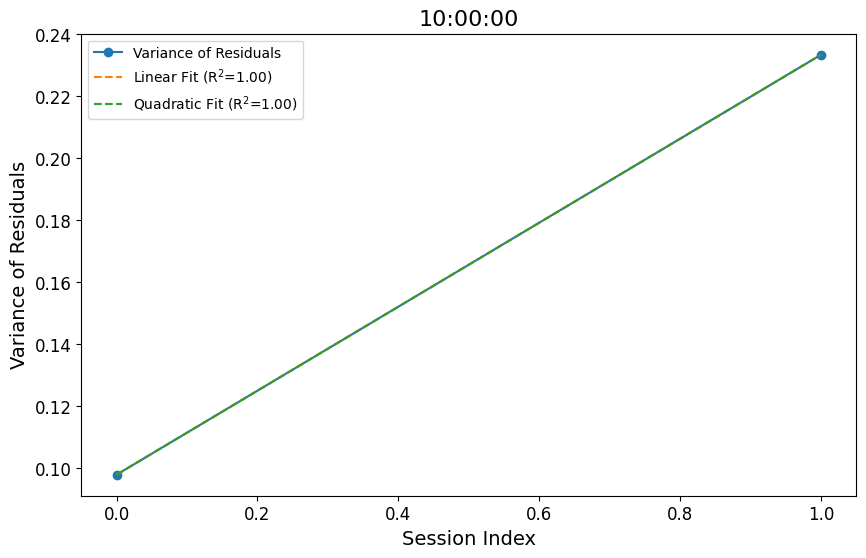

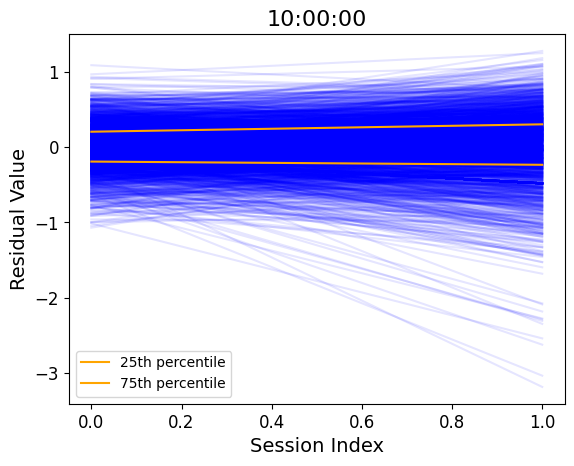

Plotting residuals variance for time_of_day: 11:00:00
(2080, 2)


/tmp/ipykernel_1550129/2570885129.py:7: RankWarning: Polyfit may be poorly conditioned
  plot_res_variance(res, groupedby=time_of_day)


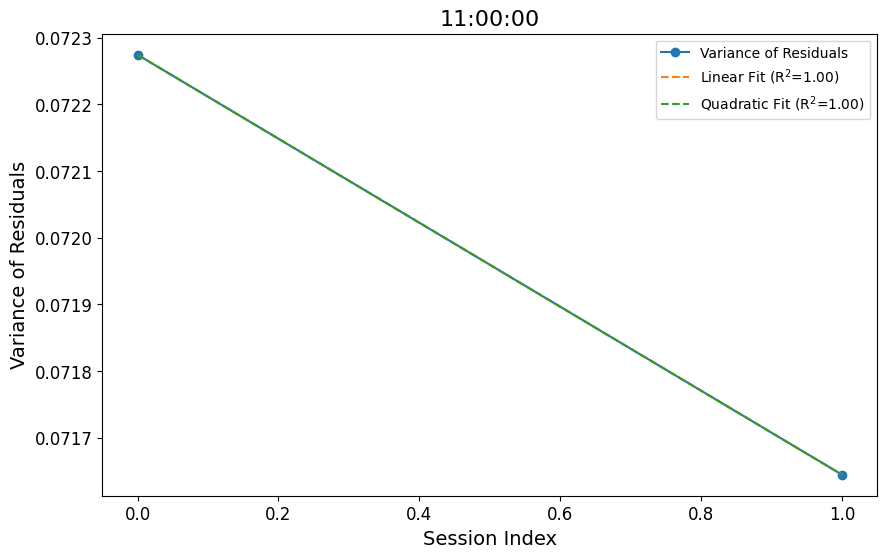

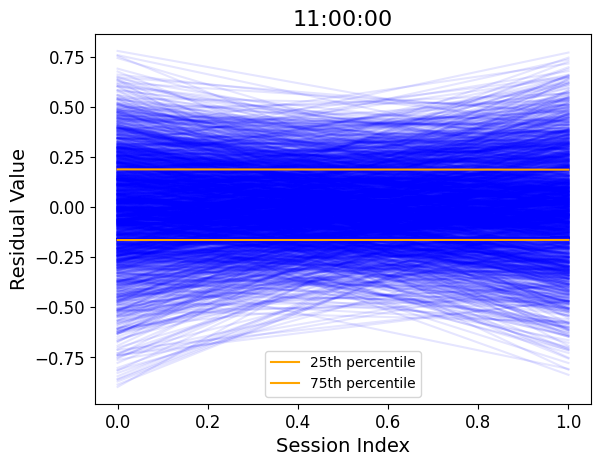

Plotting residuals variance for time_of_day: 12:00:00
(2080, 3)


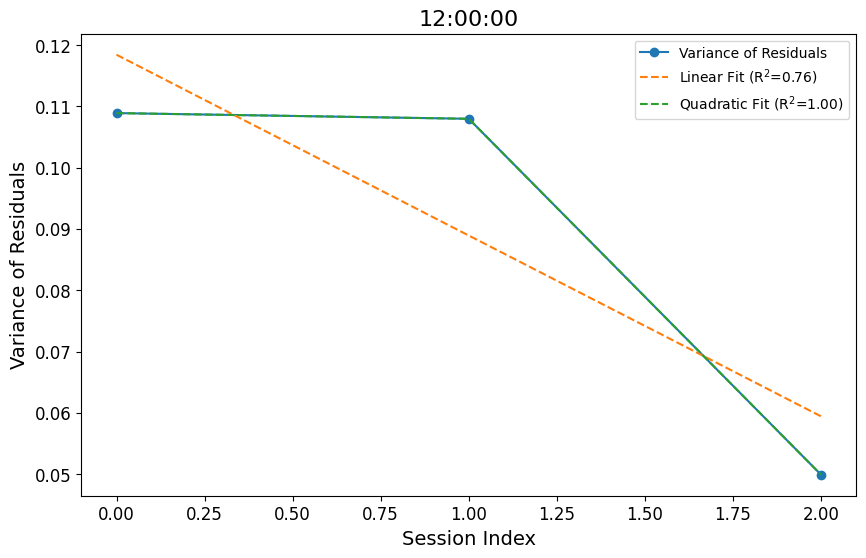

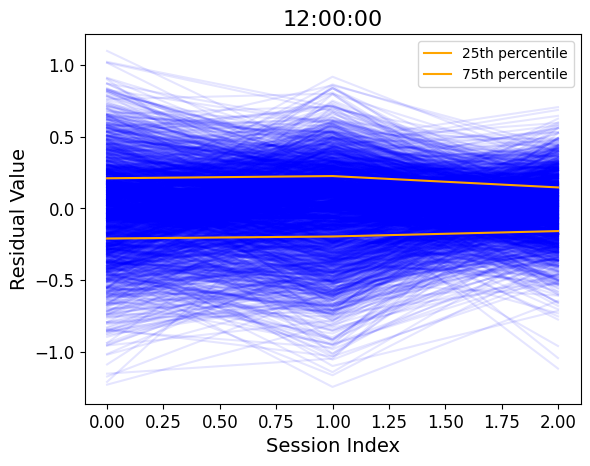

Plotting residuals variance for time_of_day: 18:00:00
(2080, 2)


/tmp/ipykernel_1550129/2570885129.py:7: RankWarning: Polyfit may be poorly conditioned
  plot_res_variance(res, groupedby=time_of_day)


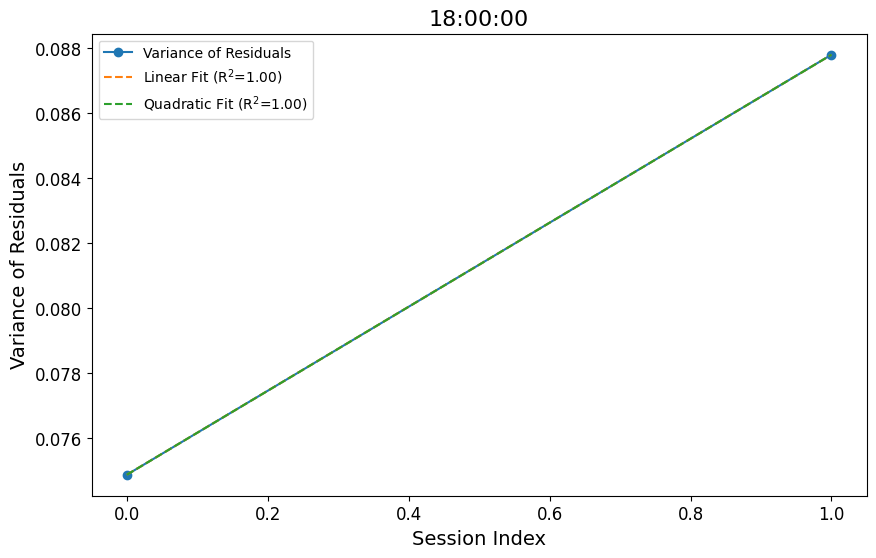

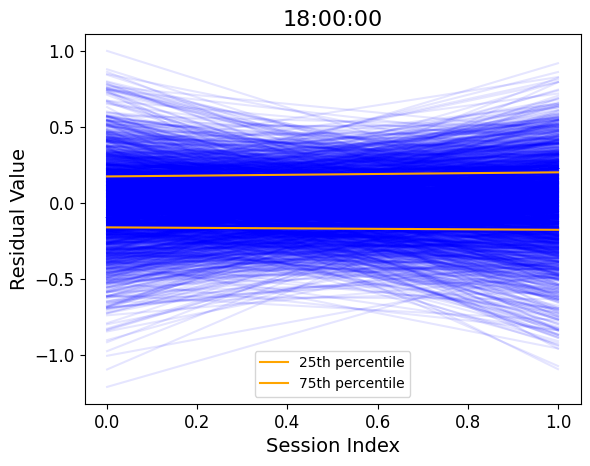

Plotting residuals variance for time_of_day: 19:00:00
(2080, 2)


/tmp/ipykernel_1550129/2570885129.py:7: RankWarning: Polyfit may be poorly conditioned
  plot_res_variance(res, groupedby=time_of_day)


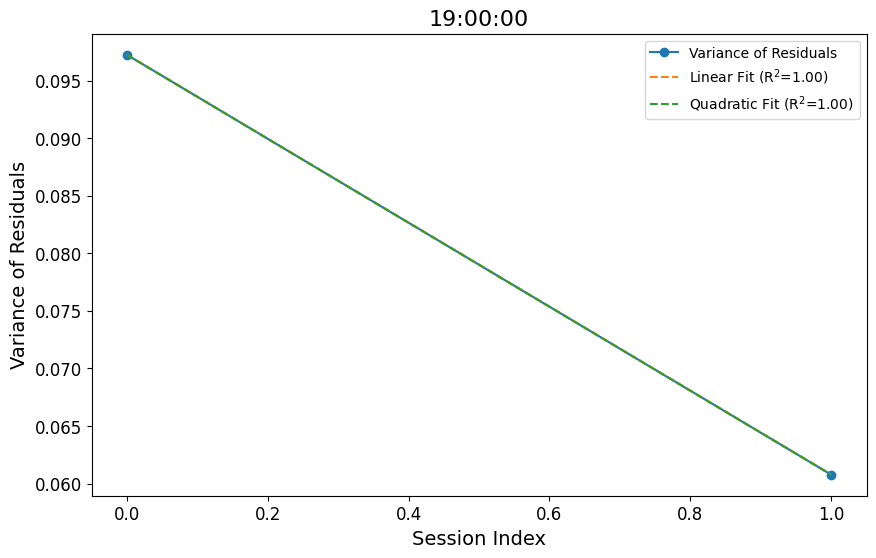

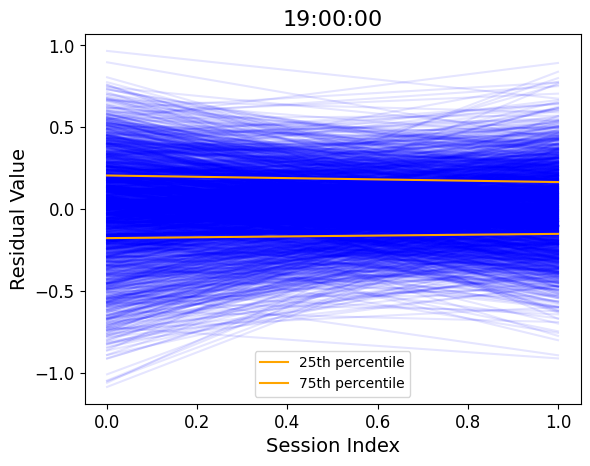

Plotting residuals variance for time_of_day: 20:00:00
(2080, 11)


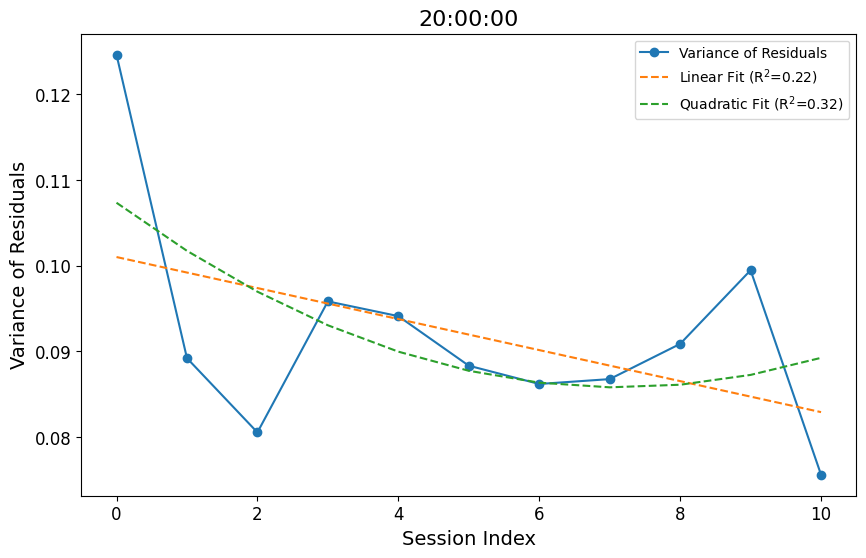

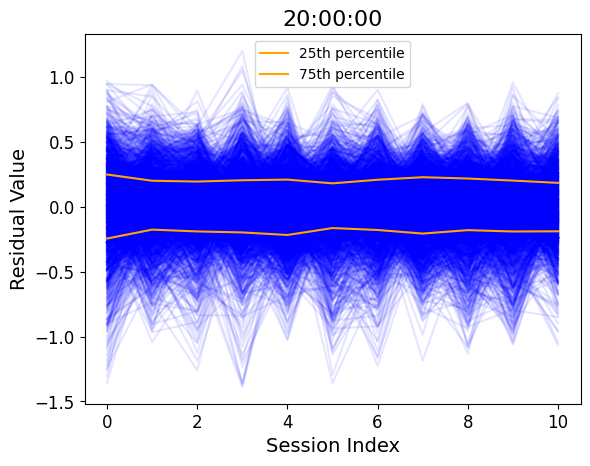

Plotting residuals variance for time_of_day: 21:00:00
(2080, 5)


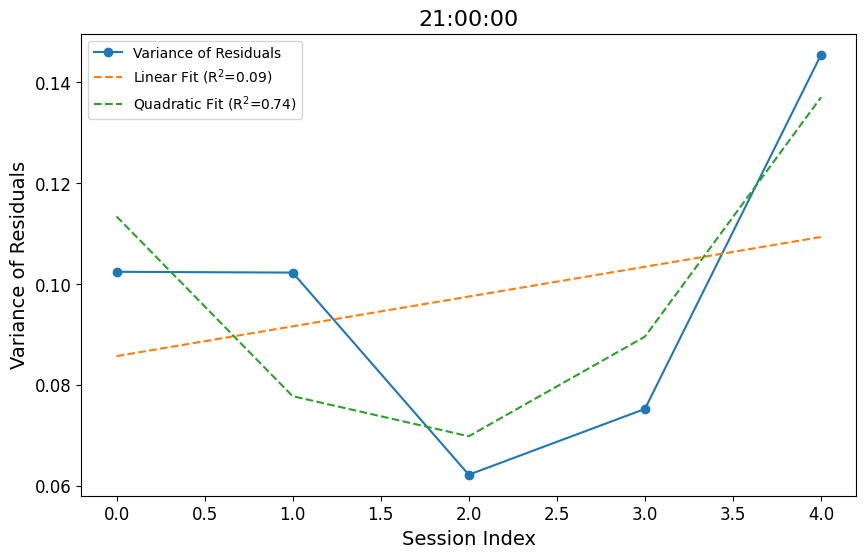

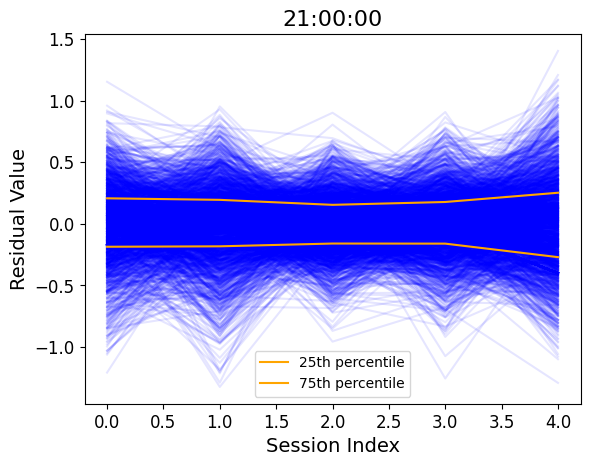

Plotting residuals variance for time_of_day: 22:00:00
(2080, 7)


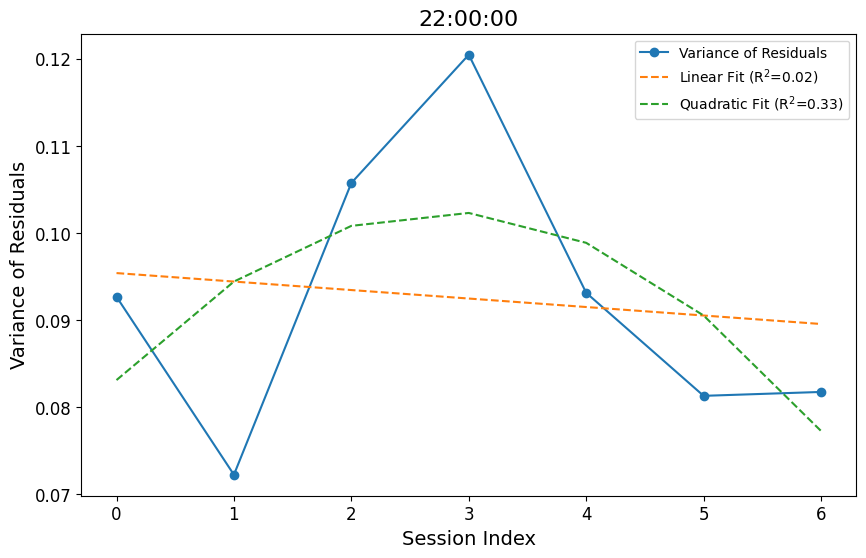

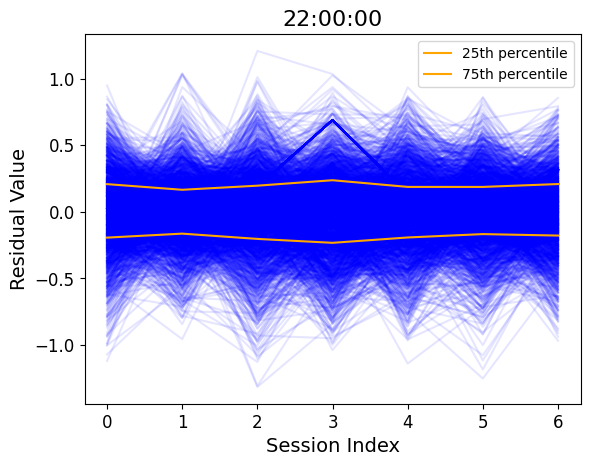

Plotting residuals variance for time_of_day: 23:00:00
(2080, 1)


In [162]:
# Group by time_of_day and plot residuals variance for each group
for time_of_day, group in residuals_df.groupby('time_of_day'):
    print(f"Plotting residuals variance for time_of_day: {time_of_day}")
    res = group.drop(columns=['session', 'day_of_week', 'time_of_day']).values.T
    print(group.drop(columns=['session', 'day_of_week', 'time_of_day']).values.T.shape)
    if res.shape[1] > 1:
        plot_res_variance(res, groupedby=time_of_day)
        plot_edgewise_residual(res, groupedby=time_of_day)